In [66]:
import warnings
warnings.filterwarnings("ignore")
# Environment check
import sys, torch, transformers, datasets, sklearn

print("Python version:", sys.version)
print("which python:", sys.executable)
print("PyTorch version:", torch.__version__)
print("Transformers version:", transformers.__version__)
print("Datasets version:", datasets.__version__)
print("CUDA available:", torch.cuda.is_available())


Python version: 3.10.2 (v3.10.2:a58ebcc701, Jan 13 2022, 14:50:16) [Clang 13.0.0 (clang-1300.0.29.30)]
which python: /Users/hd/Desktop/EMOTION-PRED/.venv/bin/python
PyTorch version: 2.4.1
Transformers version: 4.44.2
Datasets version: 4.4.1
CUDA available: False


In [67]:
# Import core libraries

# Hugging Face
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig
)
from datasets import load_dataset
from huggingface_hub import list_datasets

# Data and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation and metrics
from sklearn.metrics import classification_report, confusion_matrix

# System utilities
import os
import re
import json
import torch



In [68]:

# Step -- 2 Search all datasets mentioning "emotion" (limit to 50)
datasets_list = list_datasets(search="emotion", limit=50)

records = []
for ds in datasets_list:
    # Safely get attributes (handle None cases)
    card = ds.cardData or {}
    desc = card.get("description") or ""
    tasks = card.get("task_categories") or []
    
    records.append({
        "id": ds.id,
        "downloads": getattr(ds, "downloads", None),
        "likes": getattr(ds, "likes", None),
        "task_categories": tasks,
        "description": desc[:120]  # first 120 chars for readability
    })

df = pd.DataFrame(records)
pd.set_option("display.max_rows", None)
display(df)


,id,downloads,likes,task_categories,description
0,dair-ai/emotion,27652,410,[],
1,google-research-datasets/go_emotions,10074,239,[],
2,seara/ru_go_emotions,981,17,[],
3,tukey/human_face_emotions_roboflow,79,6,[],
4,BAAI/IndustryCorpus2_literature_emotion,190,3,[],
5,stapesai/ssi-speech-emotion-recognition,175,6,[],
6,zzhdbw/Simplified_Chinese_Multi-Emotion_Dialog...,394,7,[],
7,VModiDataWorks/indian_emotion_toned_dialogue_d...,24,1,[],
8,Mansooreh/sharif-emotional-speech-dataset,22,1,[],
9,Pyjay/emotion_nl,9,0,[],


In [69]:
# Step 3 — Load pre-annotated emotion dataset
dataset = load_dataset("emotion")
dataset_name = "emotion"

# Check available splits
print(dataset)

# View label names
label_names = dataset["train"].features["label"].names
print("Labels:", label_names)

# Quick preview
dataset["train"][0]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
Labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


{'text': 'i didnt feel humiliated', 'label': 0}

In [70]:
# Step 4 — Prepare a manageable test subset
sample_size = 1000  # You can adjust later
texts = dataset["test"]["text"][:sample_size]
true_labels = dataset["test"]["label"][:sample_size]

print("Sample text example:", texts[0])
print("True label:", label_names[true_labels[0]])


Sample text example: im feeling rather rotten so im not very ambitious right now
True label: sadness


In [71]:
# Step 5 — Define models to evaluate
MODEL_NAMES = [
    "j-hartmann/emotion-english-distilroberta-base",
    "j-hartmann/emotion-english-roberta-large",
    "nateraw/bert-base-uncased-emotion",
    "joeddav/distilbert-base-uncased-go-emotions-student",
    "cardiffnlp/twitter-roberta-base-emotion"
]


In [72]:

# Folder to store built-in emotion label sets
BUILTIN_DIR = "built_in_emotions"
os.makedirs(BUILTIN_DIR, exist_ok=True)

for model_name in MODEL_NAMES:
    try:
        print(f"Inspecting {model_name} ...")

        # Load config (no weights needed)
        config = AutoConfig.from_pretrained(model_name)
        id2label = getattr(config, "id2label", None)
        label2id = getattr(config, "label2id", None)

        # Extract label list (some configs only have label2id)
        if id2label:
            labels = list(id2label.values())
        elif label2id:
            labels = list(label2id.keys())
        else:
            labels = []

        # Build metadata
        meta = {
            "model_name": model_name,
            "num_labels": len(labels),
            "labels": labels
        }

        # Safe file name
        safe_name = re.sub(r"[^a-zA-Z0-9]", "_", model_name)
        json_path = f"/Users/hd/Desktop/EMOTION-PRED/src/built_in_emotions/{safe_name}.json"

        # Write JSON
        with open(json_path, "w") as f:
            json.dump(meta, f, indent=4)

        print(f"Saved → {json_path}")

    except Exception as e:
        print(f"Failed for {model_name}: {e}")

print("All built-in emotion label sets exported.")


Inspecting j-hartmann/emotion-english-distilroberta-base ...
Saved → /Users/hd/Desktop/EMOTION-PRED/src/built_in_emotions/j_hartmann_emotion_english_distilroberta_base.json
Inspecting j-hartmann/emotion-english-roberta-large ...
Saved → /Users/hd/Desktop/EMOTION-PRED/src/built_in_emotions/j_hartmann_emotion_english_roberta_large.json
Inspecting nateraw/bert-base-uncased-emotion ...
Saved → /Users/hd/Desktop/EMOTION-PRED/src/built_in_emotions/nateraw_bert_base_uncased_emotion.json
Inspecting joeddav/distilbert-base-uncased-go-emotions-student ...
Saved → /Users/hd/Desktop/EMOTION-PRED/src/built_in_emotions/joeddav_distilbert_base_uncased_go_emotions_student.json
Inspecting cardiffnlp/twitter-roberta-base-emotion ...
Saved → /Users/hd/Desktop/EMOTION-PRED/src/built_in_emotions/cardiffnlp_twitter_roberta_base_emotion.json
All built-in emotion label sets exported.


In [73]:
# Step 6 — Evaluation function
def evaluate_model(model_name, texts, true_labels, label_names, sample_limit=200):
    """
    Run inference on a given model and compute precision, recall, F1, confusion matrix.
    Handles different model architectures automatically.
    """
    print(f"\n🔹 Evaluating model: {model_name}")
    model_name_low = model_name.lower()

    # --- CASE 1: T5 (text2text generation) ---
    if "t5" in model_name_low:
        clf = pipeline("text2text-generation", model=model_name, tokenizer=model_name)

        def classify(text):
            result = clf(f"classify emotion: {text}")[0]["generated_text"]
            return result.strip().lower()

    # --- CASE 2: SamLowe / GoEmotions (multi-label classification) ---
    elif "go_emotions" in model_name_low:
        clf = pipeline("text-classification", model=model_name, tokenizer=model_name, return_all_scores=True)

        def classify(text):
            results = clf(text)[0]
            best = sorted(results, key=lambda x: x["score"], reverse=True)[0]
            return best["label"].lower()

    # --- CASE 3: CardiffNLP (twitter) ---
    elif "cardiffnlp" in model_name_low:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)
        labels = ['anger', 'joy', 'optimism', 'sadness']

        def classify(text):
            inputs = tokenizer(text, return_tensors="pt")
            with torch.no_grad():
                logits = model(**inputs).logits
            pred = torch.softmax(logits, dim=1)
            label = labels[torch.argmax(pred).item()]
            return label.lower()

    # --- CASE 4: Default (simple classifier) ---
    else:
        clf = pipeline("text-classification", model=model_name, tokenizer=model_name, top_k=1 ,device=0)

        def classify(text):
            result = clf(text)[0]
            if isinstance(result, list):  # handle list-of-dicts case
                result = result[0]
            return result["label"].lower()

    # --- RUN PREDICTIONS ---
    preds = []
    for t in texts[:sample_limit]:
        try:
            preds.append(classify(t))
        except Exception as e:
            preds.append("unknown")


 
    # --- ALIGN LABELS ---
    pred_indices = [label_names.index(p) if p in label_names else -1 for p in preds]
    valid_idx = [i for i, x in enumerate(pred_indices) if x != -1]

    y_true = [true_labels[i] for i in valid_idx]
    y_pred = [pred_indices[i] for i in valid_idx]

    # --- METRICS ---
    report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    cm = confusion_matrix(y_true, y_pred)

    # --- Log missing labels ---
    predicted_classes = set([label_names[i] for i in pred_indices if i != -1])
    missing = set(label_names) - predicted_classes
    if missing:
        print(f"Model did not predict these classes: {', '.join(missing)}")
    else:
        print("Model predicted all emotion classes.")

    

    return df_report, cm



🔹 Evaluating model: j-hartmann/emotion-english-distilroberta-base


Model did not predict these classes: love


,precision,recall,f1-score,support
sadness,0.920635,0.950820,0.935484,61.000000
joy,0.816901,0.935484,0.872180,62.000000
love,0.000000,0.000000,0.000000,15.000000
anger,0.928571,0.896552,0.912281,29.000000
fear,0.851852,0.821429,0.836364,28.000000
surprise,0.200000,0.500000,0.285714,4.000000
accuracy,0.839196,0.839196,0.839196,0.839196
macro avg,0.619660,0.684047,0.640337,199.000000
weighted avg,0.795915,0.839196,0.814859,199.000000


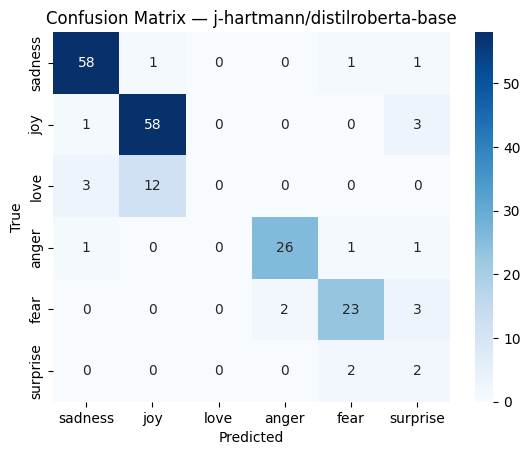

In [74]:
# Step 7 — Test one model first
report_df, cm = evaluate_model(
    "j-hartmann/emotion-english-distilroberta-base",
    texts, true_labels, label_names, sample_limit=200
)

display(report_df)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — j-hartmann/distilroberta-base")
plt.show()


In [75]:
# Step 8 — Evaluate all models
results = {}

for model in MODEL_NAMES:
    try:
        df_report, cm = evaluate_model(model, texts, true_labels, label_names, sample_limit=200)
        results[model] = df_report
    except Exception as e:
        print(f" {model} failed: {e}")



🔹 Evaluating model: j-hartmann/emotion-english-distilroberta-base
Model did not predict these classes: love

🔹 Evaluating model: j-hartmann/emotion-english-roberta-large
Model did not predict these classes: love

🔹 Evaluating model: nateraw/bert-base-uncased-emotion
Model predicted all emotion classes.

🔹 Evaluating model: joeddav/distilbert-base-uncased-go-emotions-student
Model predicted all emotion classes.

🔹 Evaluating model: cardiffnlp/twitter-roberta-base-emotion
Model did not predict these classes: surprise, fear, love


In [76]:
# Step 9 — Compare macro-F1 across models
summary = pd.DataFrame({
    model: results[model].loc["macro avg", "f1-score"]
    for model in results.keys()
}, index=["Macro F1"]).T

summary.sort_values("Macro F1", ascending=False)


,Macro F1
nateraw/bert-base-uncased-emotion,0.863528
j-hartmann/emotion-english-roberta-large,0.665317
j-hartmann/emotion-english-distilroberta-base,0.640337
joeddav/distilbert-base-uncased-go-emotions-student,0.596212
cardiffnlp/twitter-roberta-base-emotion,0.313499


In [77]:
# Step 10 — Save metrics to disk in a dedicated results folder
import os

RESULTS_DIR = f"/Users/hd/Desktop/EMOTION-PRED/src/results/results_{dataset_name}"
os.makedirs(RESULTS_DIR, exist_ok=True)  # Create if not exists

for model, df in results.items():
    safe_name = model.replace("/", "_")
    output_path = os.path.join(RESULTS_DIR, f"results_{safe_name}.csv")
    df.to_csv(output_path, index=True)
    print(f"Saved metrics → {output_path}")

print("\n All model reports saved to:", os.path.abspath(RESULTS_DIR))


Saved metrics → /Users/hd/Desktop/EMOTION-PRED/src/results/results_emotion/results_j-hartmann_emotion-english-distilroberta-base.csv
Saved metrics → /Users/hd/Desktop/EMOTION-PRED/src/results/results_emotion/results_j-hartmann_emotion-english-roberta-large.csv
Saved metrics → /Users/hd/Desktop/EMOTION-PRED/src/results/results_emotion/results_nateraw_bert-base-uncased-emotion.csv
Saved metrics → /Users/hd/Desktop/EMOTION-PRED/src/results/results_emotion/results_joeddav_distilbert-base-uncased-go-emotions-student.csv
Saved metrics → /Users/hd/Desktop/EMOTION-PRED/src/results/results_emotion/results_cardiffnlp_twitter-roberta-base-emotion.csv

 All model reports saved to: /Users/hd/Desktop/EMOTION-PRED/src/results/results_emotion
